# Algorytm Christofidesa–Serdykuova

Algorytm Christofidesa–Serdykuova jest algorytmem z ograniczeniem względnym $\frac{3}{2}$ znajdującym przybliżone rozwiązanie problemu komiwojażera dla grafu $G$.
1. Zbuduj minimalne drzewo spinające $T$ na $G$;
2. dla podgrafu $G$ indukowanego przez wierzchołki stopnia nieparzystego w $T$ znajdź najtańsze skojarzenie doskonałe $M$;
3. wyznacz obchód Eulera w multigrafie $H$ powstałym przed dodanie krawędzi $M$ do drzewa $T$;
4. zwróć cykl Hamiltona powstały przez usunięcie powtarzających się wierzchołków w obchodzie Eulera.

Poniżej tworzenie grafu losowego.

In [1]:
import networkx as nx

n = 15                  
G = nx.complete_graph(n)

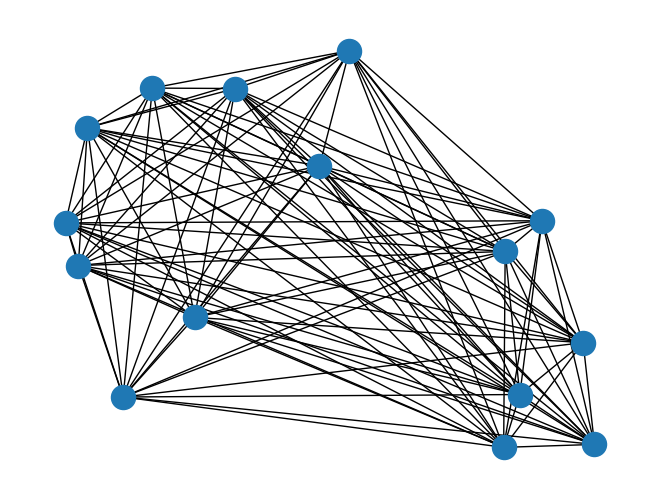

In [2]:
import random

my_pos = {i: (random.random(), random.random()) for i in G.nodes}
nx.draw(G, pos=my_pos)

Krawędziom nadajemy wagi zgodnie z położeniem wierzchołków na płaszczyźnie.

In [3]:
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['weight'] = eucl_dist(x1,y1,x2,y2)

W kolejnym kroku tworzymy minimalne drzewo spinające – będzie ono szkieletem ostatecznego cyklu Hamiltona.

In [4]:
import heapq

def mst(G: nx.Graph):
	mst = nx.Graph()
	start_node = list(G.nodes())[0]
	edges = [(0, start_node, start_node)]
	visited = set()
	while edges:
		weight, u, v = heapq.heappop(edges)
		if v in visited:
			continue
		if u != v:
			mst.add_edge(u, v, weight=weight) 
		visited.add(v)   
		for neighbor, data in G[v].items():
			if neighbor not in visited:
				heapq.heappush(edges, (data['weight'], v, neighbor))
	return mst

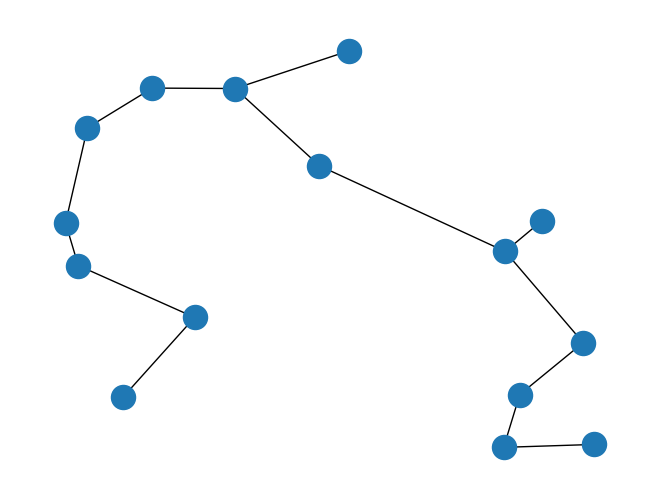

In [5]:
T = mst(G)
nx.draw(T, pos=my_pos)

Zauważmy, że każdy każdy wierzchołek w cyklu Hamiltona ma stopień 2 (jedna krawędź wchodzi, druga wychodzi).\
Z tego powodu identyfikujemy w drzewie wierzchołki o stopniu nieparzystym, które następnie poprawimy.

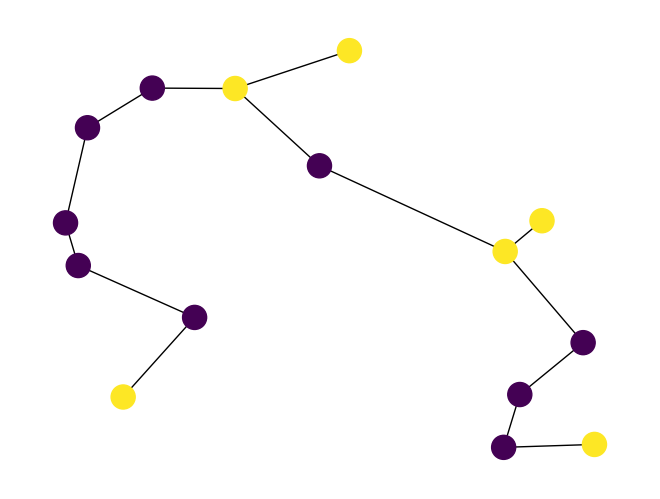

In [6]:
odd_degree_nodes = [i for i in T.nodes if T.degree(i) % 2]
node_colors = [T.degree(i) % 2 for i in T.nodes]
nx.draw(T, pos=my_pos, node_color=node_colors)

Między wierzchołkami o stopniu nieparzystym znajdujemy teraz skojarzenie doskonałe o minimalnej wadze.

In [7]:
from itertools import combinations
from math import inf

def min_weight_perfect_matching(G: nx.Graph):
    def is_perfect_matching(G: nx.Graph, matching: tuple):
        covered_nodes = set()
        for u, v in matching:
            if u in covered_nodes or v in covered_nodes:
                return False
            covered_nodes.add(u)
            covered_nodes.add(v)
        return len(covered_nodes) == len(G.nodes)

    nodes = list(G.nodes)
    if len(nodes) % 2 != 0:
        raise ValueError("Graf musi mieć parzystą liczbę wierzchołków!")
    min_weight = inf
    min_matching = None
    for matching_edges in combinations(G.edges, len(nodes) // 2):
        if is_perfect_matching(G, matching_edges):
            weight = sum(G[u][v]['weight'] for u, v in matching_edges)
            if weight < min_weight:
                min_weight = weight
                min_matching = matching_edges
    return set(min_matching)

In [8]:
matching = min_weight_perfect_matching(G.subgraph(odd_degree_nodes))
print(matching)

{(13, 14), (3, 10), (2, 7)}


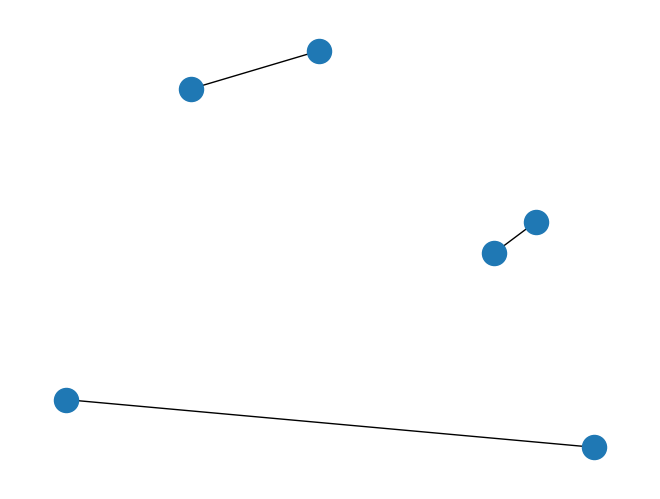

In [9]:
nx.draw(G.edge_subgraph(matching),pos=my_pos)

Znalezione krawędzie ze skojarzenia doskonałego dodajemy do grafu (może powstać multigraf).

In [10]:
M = nx.MultiGraph()

M.add_nodes_from(range(n))

M.add_edges_from(T.edges())
M.add_edges_from(matching)

print(M.edges())

[(0, 9), (0, 5), (1, 9), (1, 2), (2, 7), (3, 10), (3, 10), (4, 12), (4, 7), (5, 6), (6, 14), (8, 10), (8, 12), (10, 11), (11, 14), (13, 14), (13, 14)]


Z multigrafu tworzymy cykl Eulera.

In [11]:
initial_tour = list(nx.eulerian_circuit(M,source=0))
print(initial_tour)

[(0, 5), (5, 6), (6, 14), (14, 13), (13, 14), (14, 11), (11, 10), (10, 3), (3, 10), (10, 8), (8, 12), (12, 4), (4, 7), (7, 2), (2, 1), (1, 9), (9, 0)]


Usuwamy zbędne krawędzie z cyklu Eulera, by otrzymać cykl Hamiltona. Na przykład:
> A -> B -> A -> C => A -> B -> C

In [12]:
tour = [0]
for (i,j) in initial_tour:
    if j not in tour:
        tour.append(j)
print(tour)

[0, 5, 6, 14, 13, 11, 10, 3, 8, 12, 4, 7, 2, 1, 9]


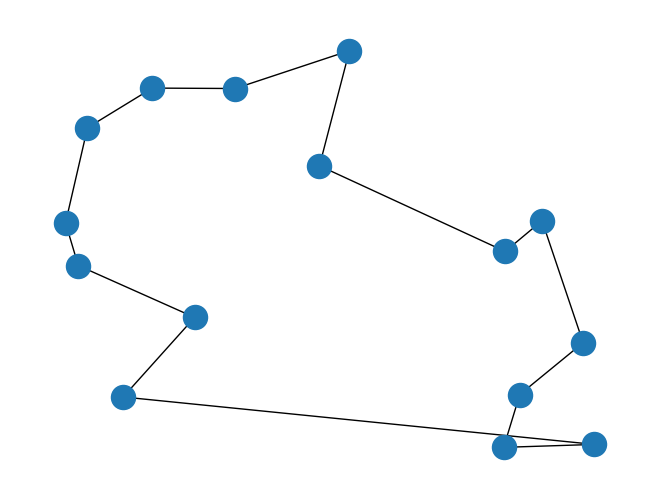

In [13]:
tour_edges = [(tour[i-1],tour[i]) for i in range(n)]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)